Figure reproduction for
# Vertical and Oblique Transmission under Fluctuating Selection
by [Yoav Ram](http://www.yoavram.com), [Uri Liberman](http://www.math.tau.ac.il/~dms/STAT-OR/liberman.htm) & [Marcus W. Feldman](http://www-evo.stanford.edu/marc.html).

This [Jupyter notebook](http://www.jupyter.org/) reproduces the figures of the manuscript.

The notebook can be viewed by pasting its URL into [nbviewer](http://nbviewer.jupyter.org/).

To run the code, you must install Python 3.5 or higher; use [Anaconda](https://store.continuum.io/) to install Python.

The latest version of this notebook is hosted on [github](https://github.com/yoavram/Milpitas).

## License
This work is licensed under a Creative Commons Attribution-ShareAlike 4.0 International License (see [README.md](https://github.com/yoavram/Milpitas/blob/master/README.md)).

## Contact
Please contact [Yoav Ram](http://www.yoavram.com) with any questions or comments on this notebook: [yoav@yoavram.com](mailto:yoav@yoavram.com).

# Setting up

## Dependencies

If you get an `ImportError` when running the next cell then you should install the missing packages by running the command `conda install <package name>` or `pip install <package name>` from a terminal or command line.

Specifically, one package that must be installed is [rakott](https://github.com/yoavram/rakott) that collects some useful utilities and [matplotlib_colorbar](https://github.com/ppinard/matplotlib-colorbar) that creates an inline colorbar.

Just run the following in a terminal:
```sh
pip install https://github.com/yoavram/rakott.git
pip install matplotlib_colorbar
```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib_colorbar.colorbar import Colorbar
import numpy as np
import scipy.stats
from scipy.integrate import quad as integral
import sympy
import numba
import pandas as pd
import seaborn as sns

In [2]:
import pickle
from concurrent.futures import ProcessPoolExecutor
import string
import warnings

from rakott.mpl import fig_xlabel, fig_ylabel, fig_panel_labels, savefig_bbox, legend_out

## Configuration

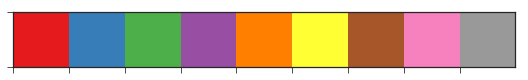

In [3]:
sns.set(style='ticks', context='paper', palette='deep')

default_palette = sns.color_palette()
colors = sns.color_palette("Set1", 9)
red, blue, green, purple, orange, yellow, brown, pink, gray = colors
sns.palplot(colors)

width, height = plt.rcParams['figure.figsize']
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.dpi'] = 300
cntr_fontsize = 14

# Basic recurrence equation

The following implements the main recurrence (eq. 2) from the main text, with the possibility of a binomial sampling (eq. 53) when $N>0$.

In [227]:
@numba.jit()
def recurrence(x, ρ, wA, wB, N=0, err=1e-14):
    N = int(N)
    wbar = x * wA + (1 - x) * wB
    # same precision around x=0 and x=1
    if np.all(x > 0.5): 
        x = 1 - (ρ * (1 - x) * wB/wbar + (1 - ρ) * (1 - x))
    else:
        x = ρ * x * wA/wbar + (1 - ρ) * x
    # move from edges to get out of non-stable equilibriums at x=0 and x=1
    if hasattr(x, 'size') and x.size > 1:
        x[x < err ] = err
        x[x > 1 - err] = 1 - err
    else:
        if x < err:
            x = err
        elif x > 1 - err:
            x = 1 - err
    if N > 0:
        x = np.random.binomial(N, x) / N
    return x

recurrence(0.5, 0.1, 1, 0.1);

## Recurrence illustration

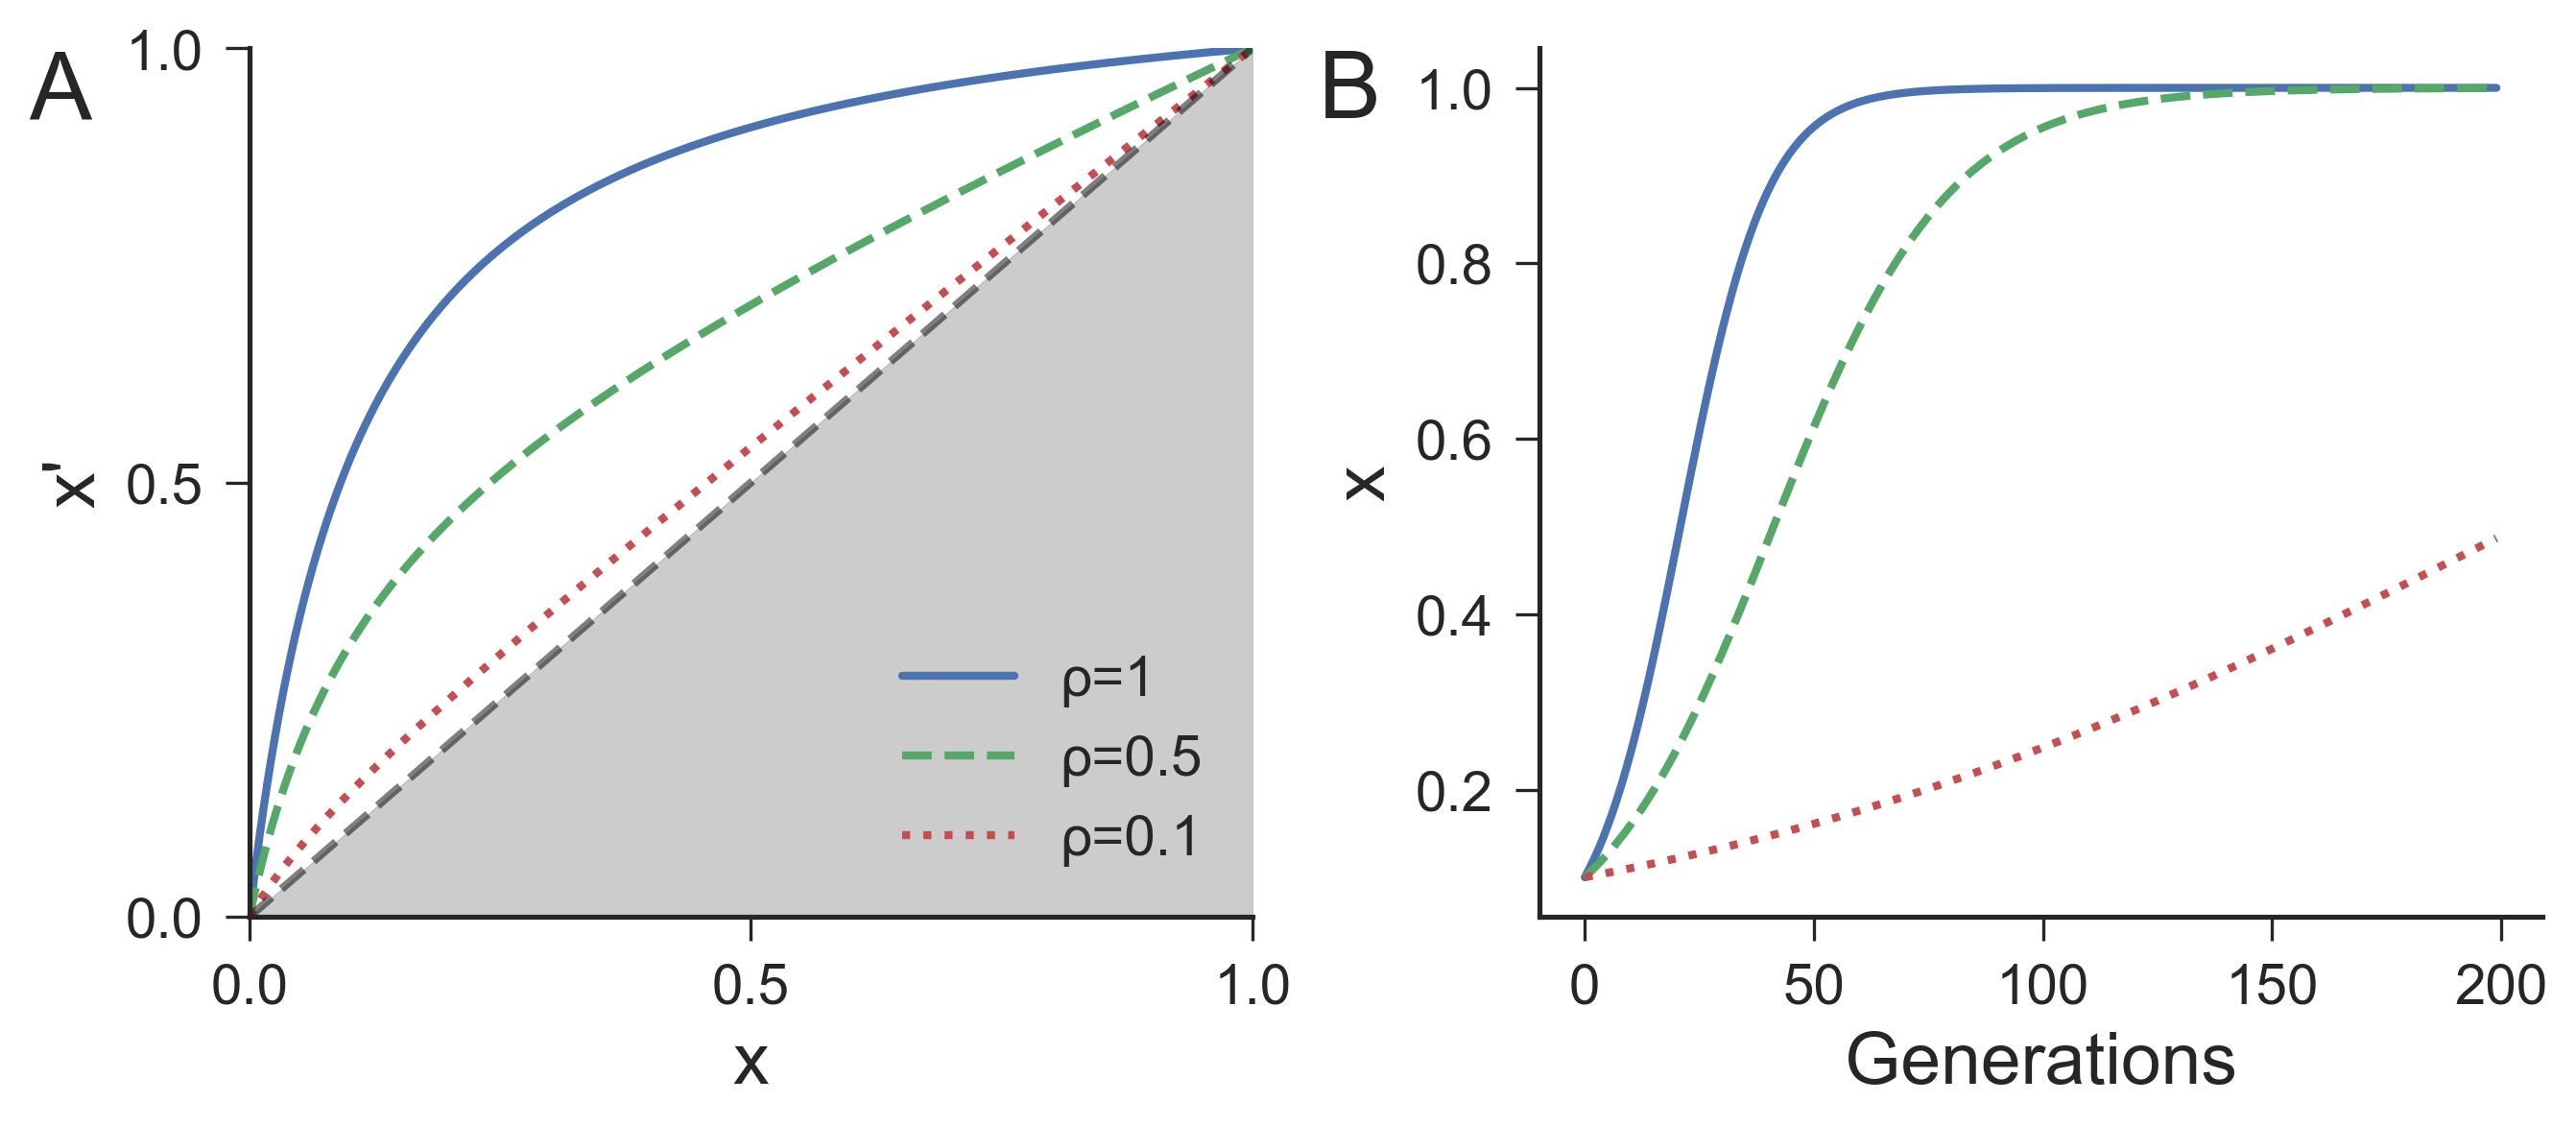

In [197]:
fig, axes = plt.subplots(1, 2, figsize=(1.5*width, height))

ax = axes[0]
x = np.linspace(0, 1, 10000)
ρs = [1, 0.5, 0.1]
W = 1
w = 0.1

for ρ, ls in zip(ρs, ('solid', 'dashed', 'dotted')):
    xx = recurrence(x, ρ=ρ, wA=W, wB=w)
    ax.plot(x, xx, lw=2, ls=ls, label='ρ={}'.format(ρ))
ax.plot(x, x, ls='--', alpha=0.5, lw=2, color='k')
ax.fill_between(x, x, color='k', alpha=0.2)

ax.set(
    xlabel='x',
    ylabel='x\'',
    xlim=(0, 1),
    ylim=(0, 1),
    xticks=np.linspace(0, 1, 3),
    yticks=np.linspace(0, 1, 3),
)
ax.legend()

ax = axes[1]
w = 0.9
n = 200
for ρ, ls in zip(ρs, ('solid', 'dashed', 'dotted')):
    x = np.empty(n)
    x[0] = 0.1
    for t in range(1, n):        
        x[t] = recurrence(x[t - 1], ρ=ρ, wA=W, wB=w)
    ax.plot(x, lw=2, ls=ls, label='ρ={}'.format(ρ))

ax.set_xlabel('Generations')
ax.set_ylabel('x')
fig_panel_labels(axes, xcoord=-0.22)
fig.tight_layout()
sns.despine()

fig.savefig('../figures/recurrence_example.pdf')
fig.savefig('../figures/recurrence_example.png')

Cut the figure to 2 figures for presentations:

In [ ]:
from PIL import Image

im = Image.open('../figures/recurrence_example.png')
w, h = im.size
im.crop((0, 0, w/2, h)).save('../figures/recurrence_example_A.png')
im.crop((w/2, 0, w, h)).save('../figures/recurrence_example_B.png')

# A1B1

The polymorphism in AkBl is given by eq. 38.

In [ ]:
@numba.jit()
def x_star(W, w, ρ):
    return 0.5 - (W + w - np.sqrt( (1 - ρ)**2 * (W - w)**2 + 4 * W * w ))/(2 * (2 - ρ) * (W - w))

## Dynamics: A1B1

In [ ]:
N = 10000
ns = np.array([[100, 20000], [25, 20000], [50, 20000]])
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.9]
W_ = 1.0
fig, axes = plt.subplots(len(ρs), len(ws), figsize=(1.5*width, 2*height), sharex=False, sharey='col')

for i, ρ_ in enumerate(ρs):
    for j, w_ in enumerate(ws):
        ax = axes[i, j]
        n = ns[i, j]
        t_ = range(0, n, 2)
        # analytic solution
        sol = x_star(W_, w_, ρ_)
        ax.axhline(y=sol, xmin=0, xmax=0.95, color=green, lw=3, ls='--', label='Equilibrium')        
        # simulation
        reps = 100
        y_ = np.empty(n, float)
        y_[0] = 0.5
        x_ = np.empty((n, reps))
        x_[0, :] = 0.5
        for t in range(1, n):
            wA_, wB_ = (w_, W_) if t % 2 == 0 else (W_, w_)
            y_[t] = recurrence(y_[t - 1], ρ=ρ_, wA=wA_, wB=wB_)
            x_[t, :] = recurrence(x_[t - 1, :], ρ=ρ_, wA=wA_, wB=wB_, N=N)
        ax.plot(t_, x_.mean(axis=1)[t_], color=orange, label='Finite population')
        ax.plot(t_, y_[t_], color=blue, lw=3, ls='-.', label='Infinite population')
        # styling
        ax.set_title(r'ρ={}, w/W={}'.format(ρ_, w_/W_))
        ax.legend().set_visible(False)

axes[0,0].legend().set_visible(True)
for i in range(2): axes[0, i].set_xlabel('')
for i in range(2): axes[1, i].set_xlabel('')
for i in range(2): axes[i, 1].set_ylabel('')
for i in range(2): axes[i, 0].set_ylabel('')

xlabel = fig_xlabel(fig, 'Cycles - $n$', ycoord=-0.02, xcoord=0.55)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ - $x_{2n}$', xcoord=0)
fig_panel_labels(axes, xcoord=-0.1, ycoord=1.05)
fig.tight_layout()
sns.despine()

fig.savefig('../figures/env_A1B1.pdf', **savefig_bbox(xlabel, ylabel))
fig.savefig('../figures/env_A1B1.png', **savefig_bbox(xlabel, ylabel))

## Equilibrium: A1B1

In [ ]:
W = 1
ws = np.logspace(-3, -0.01, 101).reshape(-1, 1)
ρs = np.linspace(0, 1, 101)

xA1B1 = x_star(W, ws, ρs)
wbarA1B1 = xA1B1 * (W - ws) + ws

ws = ws.ravel()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(width*1.75, height))

ax = axes[0]
im = ax.pcolormesh(ρs, ws, xA1B1, cmap='viridis', vmin=0, vmax=0.5, rasterized=True)
cntr = ax.contour(ρs, ws, xA1B1, levels=np.arange(0, 1.1, 0.1), linewidths=0.5, colors='k')
ax.clabel(cntr, fontsize=cntr_fontsize, fmt='%1.1f', inline=False, colors='#252525',use_clabeltext=True)
plt.colorbar(im, ax=ax, label='Stable frequency of $A$ - $x*$')
ax.set(
    yscale='log',
    ylabel=('Fitness ratio - $w/W$')
)

ax = axes[1]
im = ax.pcolormesh(ρs, ws, wbarA1B1, cmap='YlOrRd_r', vmin=0, vmax=1, rasterized=True)
cntr = ax.contour(ρs, ws, wbarA1B1, levels=np.arange(0, 0.7, 0.1), linewidths=0.5, colors='k', )
ax.clabel(cntr, fontsize=cntr_fontsize, fmt='%1.1f', inline=False, colors='#252525', use_clabeltext=True)
plt.colorbar(im, ax=ax, label=r'Stable mean fitness - $\bar{\omega}^*$')
ax.set(
    yscale='log',
)

fig_panel_labels(axes)
xlabel = fig_xlabel(fig, r'Vertical transmission rate - $\rho$', ycoord=-0.05)
fig.tight_layout(w_pad=3)

fig.savefig('../figures/A1B1_equilibrium.pdf', **savefig_bbox(xlabel))
fig.savefig('../figures/A1B1_equilibrium.png', **savefig_bbox(xlabel))

# A1B2

## Equilibrium: A1B2

Express the A1B2 model with [SymPy](http://sympy.org) by defining the polynomial (`pol`) whose roots are the equilibria in A1B2.

In [52]:
a,b,c,d,e,f,g,h = sympy.symbols('a,b,c,d,e,f,g,h'.replace(',', ' '))
x, ρ, W, w = sympy.symbols('x ρ W w')

In [53]:
x1 = x*(a*x+b)/(c*x+d)
x2 = x1*(e*x1+f)/(g*x1+h)
x3 = x2*(e*x2+f)/(g*x2+h)
x3 = sympy.simplify(x3)

x3num, x3denom = x3.as_numer_denom()
pol = (x3denom*x - x3num).subs(dict(
    e = -a,
    f = ρ*w + (1-ρ)*W,
    g = -c,
    h = W
)).subs(dict(
    a = (1-ρ)*(W-w),
    b = ρ*W + (1-ρ)*w,
    c = W-w,
    d = w,
)).as_poly(x)

assert (pol(0), pol(1)) == (0,0), (pol(0), pol(1))

Find the roots of the polynomial for different values of $w$ and $\rho$ (this will take a few minutes):

In [135]:
def calc_root(w_, ρ_):
    pol_roots = np.array(sympy.polys.rootoftools.roots(
        pol.subs({W:1, w:w_, ρ:ρ_}).as_poly(x), multiple=True, filter='R'
    ))
    pol_roots = pol_roots[np.isreal(pol_roots)].astype(float)
#     print(pol_roots)
    idx = (pol_roots > 0) & (pol_roots < 1) & (~np.isclose(pol_roots, 1)) & (~np.isclose(pol_roots, 0))
    pol_roots = pol_roots[idx]
    if len(pol_roots) > 1:
        print("More than 1! w={}, ρ={}".format(w_, ρ_))
    if len(pol_roots) == 1:
        return pol_roots[0]
    else:
        return 0
    
calc_root(0.1, 0.1);

In [152]:
ws = np.linspace(1e-4, 0.5, 50)
ρs = np.linspace(1e-4, 1-1e-4, 51) 

In [74]:
roots = np.array([[
        calc_root(w_, ρ_)
        for w_ in ws
    ]
    for ρ_ in ρs
])

Find the geometric mean fitness corresponding to each equilibrium:

In [136]:
def calc_wbar(x0, w_, ρ_):
    x1 = recurrence(x0, ρ_, 1, w_) 
    x2 = recurrence(x1, ρ_, w_, 1) 
    return scipy.stats.gmean(
        [(x0 * (1 - w_) + w_), (x1 * (w_ - 1) + 1), (x2 * (w_ - 1) + 1)]
    )

calc_wbar(0.1, 0.1, 0.1);

In [92]:
wbar = np.array([[
        calc_wbar(roots[i,j], w_, ρ_)
        for j, w_ in enumerate(ws)
    ]
    for i, ρ_ in enumerate(ρs)
])

Plot $x^*$ and $\bar{w}^*$:

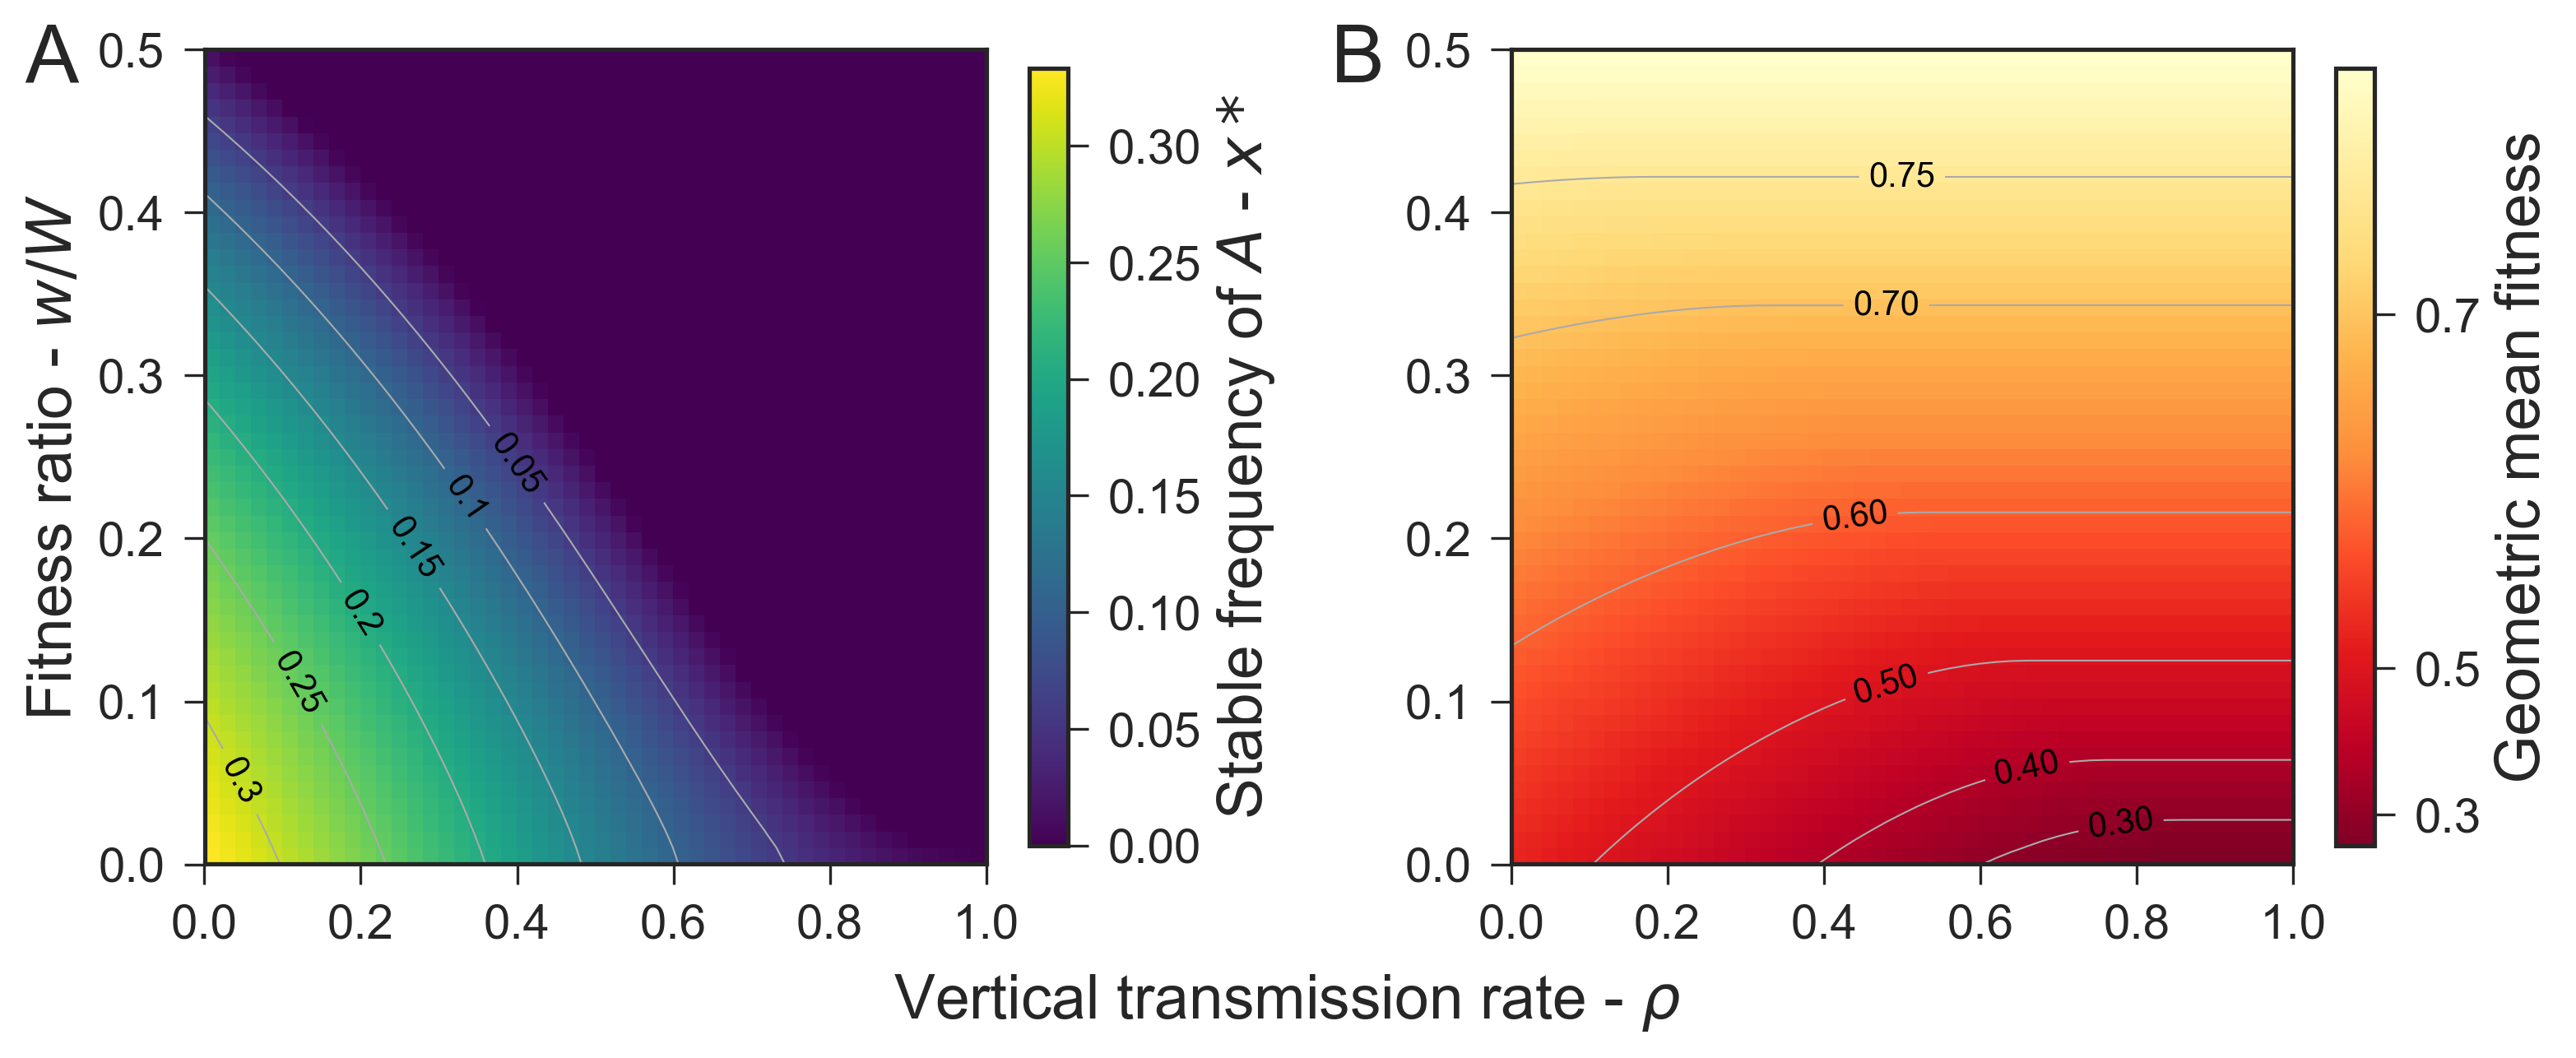

In [212]:
fig, axes = plt.subplots(1, 2, figsize=(width*1.75, height))

ax = axes[0]
im = ax.pcolormesh(ρs, ws, roots.T, cmap='viridis', rasterized=True)
cb = plt.colorbar(im, ax=ax, fraction=0.045, label='Stable frequency of $A$ - $x*$')
cntr = ax.contour(ρs, ws, roots.T, levels=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3], colors='#aaaaaa', linewidths=0.5)
ax.clabel(cntr, fontsize=10, fmt='%1.2g', inline=True, colors='k',use_clabeltext=True)
ax.set_ylabel(r'Fitness ratio - $w/W$')

ax = axes[1]
im = ax.pcolormesh(ρs, ws, wbar.T, cmap='YlOrRd_r', norm=mpl.colors.PowerNorm(3), rasterized=True)
cb = plt.colorbar(im, ax=ax, ticks=[0.3, 0.5, 0.7], fraction=0.045, label='Geometric mean fitness')
cntr = ax.contour(ρs, ws, wbar.T, levels=[0.3, 0.4, 0.5, 0.6, 0.7, 0.75], colors='#aaaaaa', linewidths=0.5)
ax.clabel(cntr, fontsize=10, fmt='%1.2f', inline=True, colors='k',use_clabeltext=True)

fig_panel_labels(axes, ycoord=0.96, xcoord=-0.23)
xlabel = fig_xlabel(fig, r'Vertical transmission rate - $\rho$', ycoord=-0.05)
fig.tight_layout(w_pad=4)

fig.savefig('../figures/A1B2_polymorphism.pdf', **savefig_bbox(xlabel))
fig.savefig('../figures/A1B2_polymorphism.png', **savefig_bbox(xlabel))

## Sensitivity to initial conditions: A1B2

In [ ]:
N = 10000
ns = np.array([[100, 4000], [50, 1000], [50, 400]])
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.9]
W_ = 1.0

In [ ]:
fig, axes = plt.subplots(len(ρs), len(ws), figsize=(1.5*width, 2*height), sharex=False, sharey="col")

for i, ρ_ in enumerate(ρs):
    for j, w_ in enumerate(ws):
        ax = axes[i, j]
        n = ns[i, j]
        t_ = range(0, n, 3)
        y_ = np.empty((n, 10), float)
        y_[0, :] = np.linspace(0.01, 0.99, 10)
        for t in range(1, n):
            wA, wB = (W_, w_) if t % 3 == 2 else (w_, W_)
            y_[t] = recurrence(y_[t - 1], ρ_, wA, wB)
        ax.plot(t_, y_[t_], color=blue, lw=3, ls='-', label='Infinite population')
        # styling
        ax.set_title(r'ρ={}, w/W={}'.format(ρ_, w_/W_))
        ax.set_ylim(0, 1)
        ax.legend().set_visible(False)

for i in range(2): axes[0, i].set_xlabel('')
for i in range(2): axes[1, i].set_xlabel('')
for i in range(2): axes[i, 1].set_ylabel('')
for i in range(2): axes[i, 0].set_ylabel('')

xlabel = fig_xlabel(fig, 'Cycles - $n$', xcoord=0.55, ycoord=-0.02)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ - $x_{3n}$', xcoord=0)
labels = fig_panel_labels(axes, ycoord=1.1)
fig.tight_layout()
sns.despine()

fig.savefig('../figures/env_A1B2.pdf', **savefig_bbox(xlabel, ylabel, *labels))
fig.savefig('../figures/env_A1B2.png', **savefig_bbox(xlabel, ylabel, *labels))

# AkBl
## Polymorphism vs. fixation

The boundary between polymorphism and fixation is found in eq. 22.

In [ ]:
def polymorphism_boundary(s, ρ):
    res = -np.log(1+ρ*s/(1-s))/np.log(1-ρ*s) 
    try:
        res[ρ*s == 0] = np.inf
    except TypeError:
        if ρ*s == 0:
            res = np.inf
    return res

We find the boundary and plot it for different values of $\rho$ and $s=W-w$.

In [ ]:
ss = [0.1, 0.5, 0.9, 0.99]
ρs = [0.01, 0.1, 0.2, 0.5]

ρ = np.linspace(0.001, 0.999, 1000)
s = np.linspace(0.001, 0.999, 1000)

In [ ]:
sns.set_palette('RdBu', 2)

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(1.25*width, 3*height), sharex='col')

for ax, s_ in zip(axes[:, 0], ss):
    boundry = polymorphism_boundary(s_, ρ)
    ymax = boundry.max()
    ax.fill_between(ρ, boundry, ymax)
    ax.fill_between(ρ, boundry)
    ax.set(
        ylim=(1, ymax),
        xlim=(ρ.min(), ρ.max()),
        yticks=np.linspace(1, np.ceil(ymax), 4, dtype=int),
        title=('s={}'.format(s_)),
    )
    
ymax00 = polymorphism_boundary(ss[0], ρ).max()
axes[0, 0].set(
    title=('Fitness difference:\ns={}'.format(ss[0])),
    yticks=(1, round((ymax00+1)/2, 2), round(ymax00, 2))
)
axes[-1, 0].set(
    xlabel=r'Vertical transmission rate - $\rho$',
)
    
for ax, ρ_ in zip(axes[:, 1], ρs):
    boundry = polymorphism_boundary(s, ρ_)
    ymax = boundry.max()
    ax.fill_between(s, boundry, ymax)
    ax.fill_between(s, boundry)
    ax.set(
        ylim=(1, ymax),
        xlim=(s.min(), s.max()),
        title=('ρ={}'.format(ρ_)),
    )
axes[0, 1].set(
    title=('Vertical transmission rate:\nρ={}'.format(ρs[0])),
)
axes[-1, 1].set(
    xlabel=r'Fitness difference - $s$',
)

axes[0, 1].legend(['fixation', 'polymorphism', ], frameon=True, loc='upper right')
ylabel = fig_ylabel(fig, r'Environment period ratio - $k/l$', xcoord=0.03)
fig_panel_labels(axes, xcoord=0, ycoord=1.025)
fig.tight_layout()

fig.savefig('../figures/lk_phase_plane.pdf', **savefig_bbox(ylabel))
fig.savefig('../figures/lk_phase_plane.png', **savefig_bbox(ylabel))

In [ ]:
sns.set_palette(default_palette)

## Optimal ρ: geometric mean fitness

Calculate geometric mean fitness:

Simulate evolution in AkBl:

In [228]:
@numba.jit()
def simulation(ρ, w, k, l, x0=0.5, n=10000):
    wA = np.array(([1]*k + [w]*l) * n, dtype=float)
    wB = np.array(([w]*k + [1]*l) * n, dtype=float)
    
    ρ = np.array(ρ, ndmin=1)
    x = np.empty((wA.size, ρ.size))
    x_prev = np.empty((k+l, ρ.size))
    x[0, :] = x0
    x_prev[:, :] = -1
    t = 0 # for numba
    for t in range(1, n * (k + l)):
        x[t, :] = recurrence(x[t - 1, :], ρ=ρ, wA=wA[t], wB=wB[t])
        if t % (k + l) == 0:
            if np.allclose(x[(t-k-l):t, :], x_prev, rtol=0, atol=1e-7):
                break
            x_prev = x[(t-k-l):t, :]
    assert (x_prev >= 0).all(), 'ρ={}, w={}, k={}, l={}, x[x<0]={}'.format(ρ, w, k, l, x_prev)
    assert (x_prev <= 1).all(), 'ρ={}, w={}, k={}, l={}, x[x>1]={}'.format(ρ, w, k, l, x_prev)
    if t >= n * (k + l) - 1:
        print("Reached iteration limit for ρ={}, w={}, k={}, l={}".format(ρ, w, k, l))
    return x_prev

simulation([0.1,0.2,0.3], 0.1, 1, 1);

In [223]:
ρs = np.linspace(0.0, 1.0, 101, dtype=float)
ρs[0] = 1e-10
ks = np.arange(1, 51, 1, dtype=int)

In [224]:
xAkBk01 = np.array([
    simulation(ρs, 0.1, k_, k_, n=100000)
    for k_ in ks
])
np.savez_compressed('xAkBk01.npz', xAkBk01=xAkBk01)

In [225]:
xAkBk05 = np.array([
    simulation(ρs, 0.5, k_, k_, n=100000)
    for k_ in ks
])
np.savez_compressed('xAkBk05.npz', xAkBk05=xAkBk05)

In [ ]:
xAkBk09 = np.array([
    simulation(ρs, 0.9, k_, k_, n=100000)
    for k_ in ks
])
np.savez_compressed('xAkBk09.npz', xAkBk09=xAkBk09)

In [138]:
d = np.load('xAkBk01.npz')
xAkBk01 = d['xAkBk01']
d = np.load('xAkBk05.npz')
xAkBk05 = d['xAkBk05']
d = np.load('xAkBk09.npz')
xAkBk09 = d['xAkBk09']

del d

In [139]:
def geom_avg_wbar(x, w, k, l):
    x = x[-k-l:]
    wA = np.array([1]*(k-1) + [w]*l + [1], dtype=float).reshape((k+l, 1))
    wB = np.array([w]*(k-1) + [1]*l + [w], dtype=float).reshape((k+l, 1))
    wbars = x * wA + (1 - x) * wB
    assert (wbars > 0).all(), wbars
    res = scipy.stats.mstats.gmean(wbars)
    assert (0 < res).all(), (res, k, l)
    assert (res < 1).all(), (res, k, l)
    return res

In [140]:
geomwbarAkBk01 = np.array([
    geom_avg_wbar(x, 0.1, i + 1, i + 1)
    for i, x in enumerate(xAkBk01)
])
geomwbarAkBk05 = np.array([
    geom_avg_wbar(x, 0.5, i + 1, i + 1)
    for i, x in enumerate(xAkBk05)
])
geomwbarAkBk09 = np.array([
    geom_avg_wbar(x, 0.9, i + 1, i + 1)
    for i, x in enumerate(xAkBk09)
])

Plot the geometric mean fitness for each $k$ and $\rho$:

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(width*2.5, 1.1*height))

for ax, w, wbarAkBl in zip(axes.flat, [0.1, 0.5, 0.9], [geomwbarAkBk01, geomwbarAkBk05, geomwbarAkBk09]):
    im = ax.pcolormesh(ρs, ks, wbarAkBl, cmap='YlOrRd_r', rasterized=True)
    ax.contour(ρs, ks, wbarAkBl, colors='#666666')
    ax.plot(ρs[wbarAkBl.argmax(axis=1)], ks, 'o', markersize=10, color=blue)
    cb = plt.colorbar(im, ax=ax)
    ax.set_xticks([0.01, 0.25, 0.5, 0.75, 0.99])
    ax.set_xticklabels([0.0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticks([1, 10, 20, 30, 40, 50])
    ax.set_title('$w$={}'.format(w))
    
axes[0].set_ylabel('Environment period - $k=l$')
axes[1].set_xlabel(r'Vertical transmission rate - $\rho$')
fig_panel_labels(axes, xcoord=0, ycoord=1.025)
fig.tight_layout(w_pad=2)

fig.savefig('../figures/AkBk_stable_wbar.pdf')
fig.savefig('../figures/AkBk_stable_wbar.png')

Plot just the $\rho$ that gives the maximum geometric mean fitness:

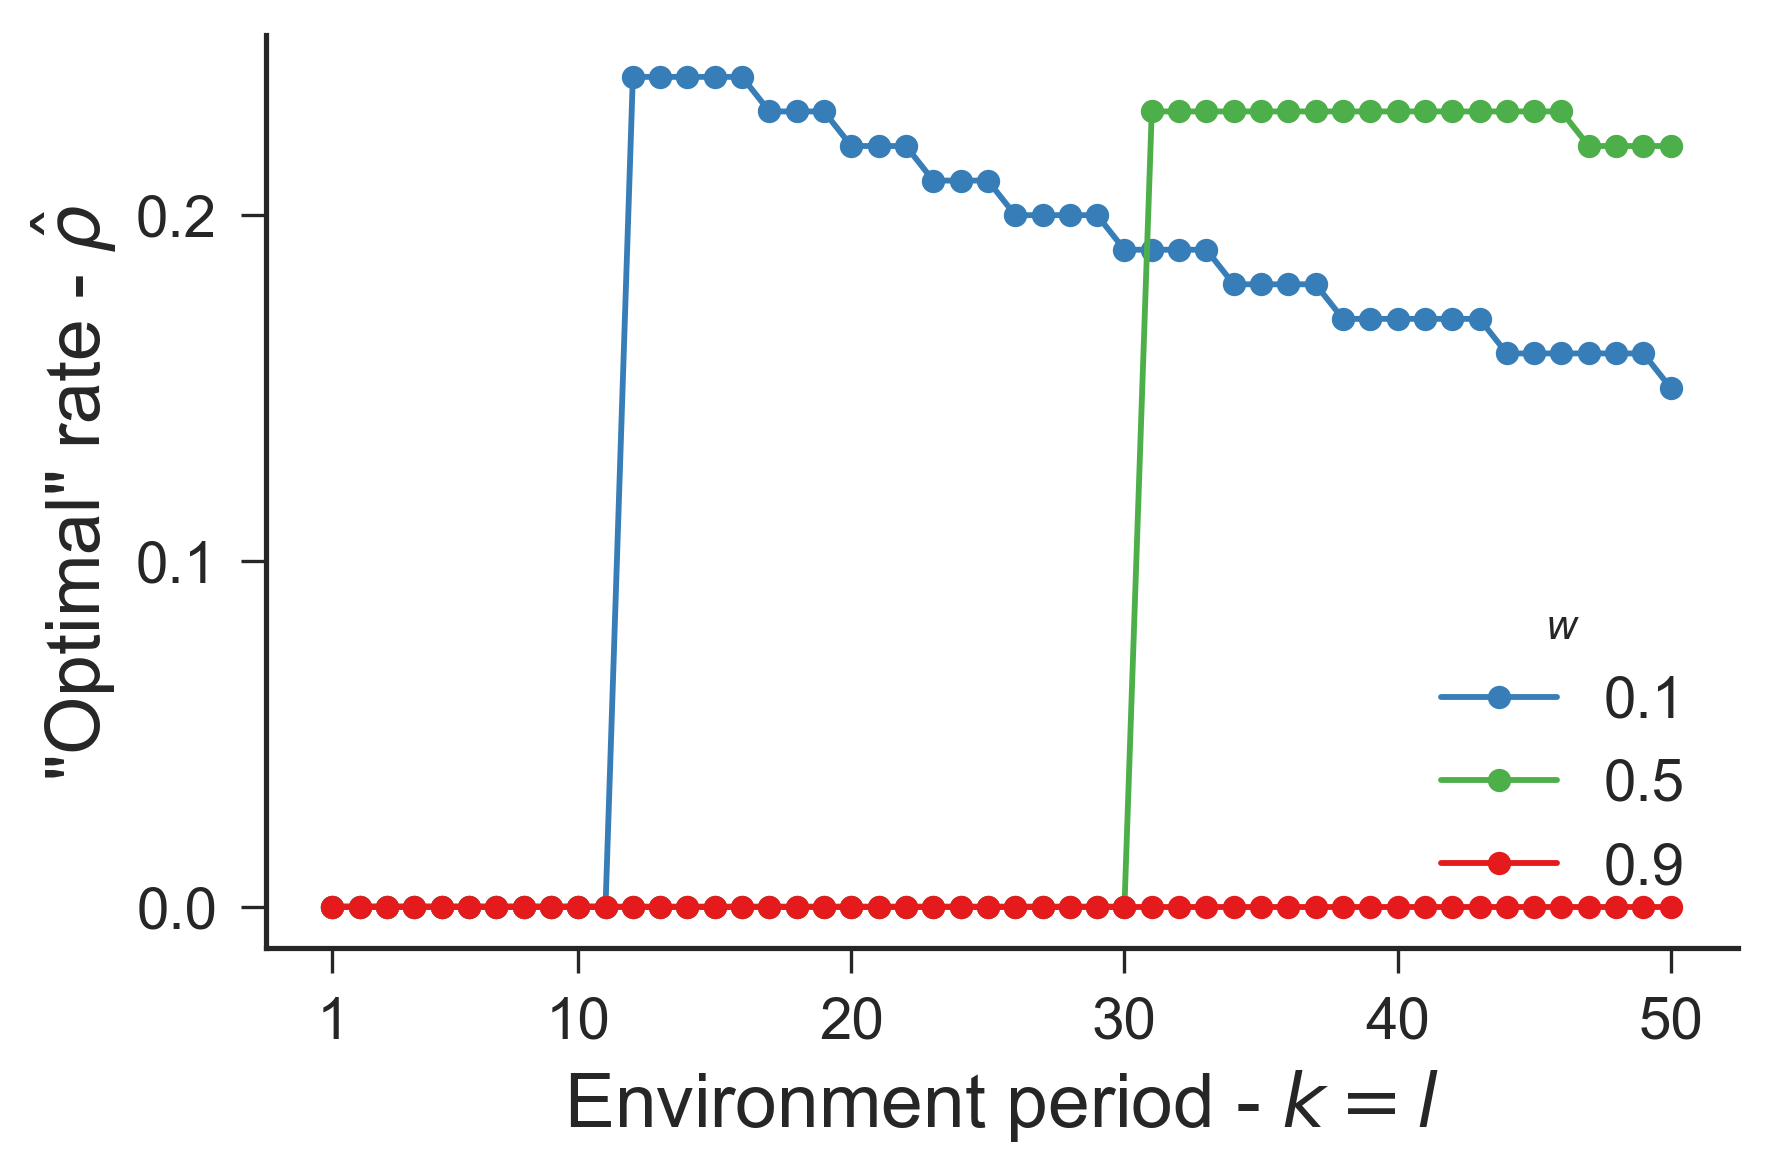

In [10]:
fig, ax = plt.subplots()

ax.plot(ks, ρs[geomwbarAkBk01.argmax(axis=1)], 'o-', label='0.1', color=blue)
ax.plot(ks, ρs[geomwbarAkBk05.argmax(axis=1)], 'o-', label='0.5', color=green)
ax.plot(ks, ρs[geomwbarAkBk09.argmax(axis=1)], 'o-', label='0.9', color=red)

ax.set(
    xlabel=('Environment period - $k=l$'),
    ylabel=(r'"Optimal" rate - $\hat{\rho}$'),
#     xlim=(1, 50),
    xticks=[1, 10, 20, 30, 40, 50],
    yticks=[0, 0.1, 0.2]
)
ax.legend(title='$w$', loc='lower right')
fig.tight_layout()
sns.despine()

fig.savefig('../figures/AkBk_stable_wbar_slice.pdf')
fig.savefig('../figures/AkBk_stable_wbar_slice.png')

## Sensitivity to initial conditions: AkBk

Simulate the recurrence in AkBl with different initial conditions $x(0)$:

In [ ]:
@numba.jit()
def simulation(x0, ρ, W, w, k, l, reps=1, n=1000):
    wA = np.array(([W]*k + [w]*l) * n, dtype=float)
    wB = np.array(([w]*k + [W]*l) * n, dtype=float)
    
    x = np.empty((wA.shape[0], x0.shape[0]))
    x[0, :] = x0

    for t in range(1, n * (k + l)):
        x[t, :] = recurrence(x[t - 1, :], ρ=ρ, wA=wA[t], wB=wB[t])

    assert (x > 0).all()
    assert (x < 1).all()
    
    return x

Do such simulations for different $\rho$, $w$ and $k=l$ values:

In [ ]:
W = 1
n = 1000
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.5]
ws_ρs = [(w,ρ) for w in ws for ρ in ρs]

x0s = np.linspace(0.01, 0.99, 10)
W_ = 1.0
ks = [1,2,3,4,5,6,7,8,9,10,20,40]

data = {}
for k in ks:
    for w, ρ in ws_ρs: 
        data[(k, w, ρ)] = simulation(x0s, ρ, W, w, k, k, n=n)

Cache results to file:

In [ ]:
with open('AkBk_init_cond.pkl', 'wb') as f:
    pickle.dump(data, f)

Load results from cache:

In [ ]:
with open('AkBk_init_cond.pkl', 'rb') as f:
    data = pickle.load(f)

Plot:

In [ ]:
n = 700

fig, axes = plt.subplots(6, 2, figsize=(1.5*width, 4*height), sharex=False, sharey=True)

for k, ax in zip(ks, axes.flat):
    lines = [] 
    for (w,ρ), color in zip(ws_ρs, colors): 
        x = data[(k, w, ρ)]
        line = ax.plot(x[:n:(2*k)], color=color, alpha=0.5)[0]
        lines.append(line)
        ax.set(
            xlabel='',
            ylabel='',
            title='$k$={}'.format(k),
            yticks=[],
        )

axes[0,0].set_yticks([0, 0.25, 0.5, 0.75, 1])
lg = legend_out(axes[0,1], 
    lines, ['w={:.1} ρ={:.1}'.format(*_) for _ in ws_ρs]
)
xlabel = fig_xlabel(fig, 'Cycles - $n$', xcoord=0.55, ycoord=-0.01)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ - $x_{2 k n}$', xcoord=0)
labels = fig_panel_labels(axes, xcoord=-0.1, ycoord=1.05)
fig.tight_layout(w_pad=3)
sns.despine()

fig.savefig('../figures/AkBk_x0.pdf', **savefig_bbox(xlabel, ylabel, lg, *labels))
fig.savefig('../figures/AkBk_x0.png', **savefig_bbox(xlabel, ylabel, lg, *labels))

##  Sensitivity to initial conditions: A3B10

Similar plot for $k \ne l$: $k=3, l=10$.

In [ ]:
ns = np.array([[200, 2000], [100, 500], [50, 200]])
ρs = [0.1, 0.5, 0.9]
ws = [0.1, 0.9]
W = 1.0

data = {}
for i, ρ in enumerate(ρs):
    for j, w in enumerate(ws):
        n = ns[i, j]
        x = np.empty((n, 10), float)
        x[0, :] = np.linspace(0.01, 0.99, 10)
        for t in range(1, n):
            wA, wB = (W, w) if t % 13 < 3 else (w, W)
            x[t] = recurrence(x[t - 1], ρ, wA, wB)
        data[(ρ, w)] = x

In [ ]:
fig, axes = plt.subplots(len(ρs), len(ws), figsize=(1.5*width, 2*height), 
                         sharex=False, sharey=True)

for i, ρ in enumerate(ρs):
    for j, w in enumerate(ws):
        ax = axes[i, j]
        n = ns[i, j]        
        x = data[(ρ, w)]  
        t = range(0, n, 13)
        ax.plot(t, x[t], color=blue, lw=3, ls='-')
        # styling
        ax.set(
            title=r'ρ={}, w/W={}'.format(ρ, w/W),
            ylim=(0, 1),
            xlabel='',
            ylabel=''
        )

axes[0,0].set_yticks([0, 0.25, 0.5, 0.75, 1])

xlabel = fig_xlabel(fig, 'Cycles - $n$', xcoord=0.55, ycoord=-0.02)
ylabel = fig_ylabel(fig, 'Frequency of phenotype $A$ - $x_{13 n}$', xcoord=0)
labels = fig_panel_labels(axes, xcoord=-0.1, ycoord=1.075)
fig.tight_layout(w_pad=2)
sns.despine()

fig.savefig('../figures/env_A3B10.pdf', **savefig_bbox(xlabel, ylabel, *labels))
fig.savefig('../figures/env_A3B10.png', **savefig_bbox(xlabel, ylabel, *labels))

# Random environment

Simulating eq. 31:

In [ ]:
@numba.jit()
def simulation(x0, n, ρ, s, p):
    x = np.empty(n)
    x[0] = x0
    s_t = np.random.choice([s, -s], size=n, replace=True, p=[p, 1-p])    
    for t in range(n-1):
        x[t + 1] = recurrence(x[t], ρ=ρ, wA=1.0 + s_t[t], wB=1.0)
    return x

x = simulation(x0=0.5, n=10000, ρ=0.1, s=0.1, p=0.5);

## Stationary distribution

In [ ]:
n = 1000000
ρ = 0.1
x0 = 1e-4

p = np.linspace(0.48, 0.52, 100)
s = np.linspace(0.01, 0.1, 100)
x = np.empty((p.size, s.size))

In [ ]:
for i, p_ in enumerate(p):
    for j, s_ in enumerate(s):
        x_ = simulation(x0=x0, n=n, ρ=ρ, s=s_, p=p_)
        x[i, j] = x_[-1]

Cache results:

In [ ]:
with open('rand_env_sim_cache.pkl', 'wb') as f:
    pickle.dump(dict(x=x, Elog=Elog, Elog_A=Elog_A, Elog_B=Elog_B), f)

Load cached results:

In [ ]:
with open('rand_env_sim_cache.pkl', 'rb') as f:
    d = pickle.load(f)
    x = d['x']

Calculate boundaries for fixations (eq. 33):

In [ ]:
p0B = np.array([-np.log(1-ρ*s_)/(np.log(1+ρ*s_) - np.log(1-ρ*s_)) for s_ in s])
p0A = np.array([-np.log(1+ρ*(1/(1-s_)-1))/(np.log(1+ρ*(1/(1+s_)-1)) - np.log(1+ρ*(1/(1-s_)-1))) for s_ in s])

Plot:

In [ ]:
fig, ax = plt.subplots(figsize=(width*1.25, height*1.5))
lines_kws = dict(color=gray, lw=3, ls='-', alpha=0.9)

im = ax.pcolormesh(s, p, x, cmap='viridis', rasterized=True)
ax.plot(s, p0A, **lines_kws)
ax.plot(s, p0B, **lines_kws)
cb = plt.colorbar(im, ax=ax, label='Final frequency of phenotype $A$')

ax.set(
    ylabel='Probability of environment favoring $A$ - $p$',
    xlabel='Selection coefficient - $s$',
    ylim=(p.min(), p.max()),
    yticks=np.linspace(p.min(), p.max(), 5),
    xlim=(s.min(), s.max()),
    xticks=np.linspace(s.min(), s.max(), 4)
)

fig.tight_layout()
fig.savefig('../figures/stochastic_env_x_t.pdf')
fig.savefig('../figures/stochastic_env_x_t.png')

## Dynamics: two iid fitness random variables

In [ ]:
@numba.jit()
def simulation(x0, ρ, wA, wB, n):
    ρ = np.array(ρ, ndmin=1)
    x = np.empty((n, ρ.size))
    x[0, :] = x0
    for t in range(n-1):        
        x[t + 1,:] = recurrence(x[t], ρ=ρ, wA=wA[t], wB=wB[t])
    return x

In [ ]:
n = 10000000

distribution = scipy.stats.expon
rv = distribution(1)
wA = rv.rvs(n)
wB = rv.rvs(n)

sns.distplot(wA, label='$w_A$', kde=False)
sns.distplot(wB, label='$w_B$', kde=False)
plt.legend();
print(wA.mean(), wB.mean())

In [ ]:
ρs = [0.5, 0.1, 0.01, 0.001]
x = simulation(1e-5, ρs, wA, wB, n)

Cache `x` to file:

In [ ]:
np.savez_compressed('stoch_two_iid_rvs.npz', x=x, ρs=ρs)

Load from cache:

In [ ]:
d = np.load('stoch_two_iid_rvs.npz')
x = d['x']
ρs = d['ρs']

del d

Plot:

In [ ]:
t = np.logspace(0, np.log10(x.shape[0]), x.shape[0]/100, dtype=int)[:-1]
t = np.unique(t)
t.size / x.shape[0]

In [ ]:
fig, ax = plt.subplots(figsize=(width*1.5, height))
ax.plot(t, x[t])
ax.axhline(0.5, color='k', ls='--')
ax.set(
    ylabel='Frequency of $A$ - $x$',
    xscale='log',
    yscale='log'
)
xlabel = ax.set_xlabel('Generations')
lg = legend_out(ax, ρs, title='ρ')

fig.savefig('../figures/stoch_two_iid_rvs.pdf', **savefig_bbox(xlabel, lg))
fig.savefig('../figures/stoch_two_iid_rvs.png', **savefig_bbox(xlabel, lg))

# Modifier model
The following implements the modifier model recursion (eq. 35):

In [5]:
@numba.jit()
def modifier_recursion(x, wA, wB, ρ, P, N=0, err=1e-14):
    x1, x2, x3, x4 = x
    x1_ = x1 * wA * ((1 - ρ) * (x1 + x3) + ρ) + x2 * wB * (1 - ρ) * (x1 + x3)
    x2_ = x1 * wA * (1 - ρ) * (x2 + x4) + x2 * wB * ((1 - ρ) * (x2 + x4) + ρ)
    x3_ = x3 * wA * ((1 - P) * (x1 + x3) + P) + x4 * wB * (1 - P) * (x1 + x3)
    x4_ = x3 * wA * (1 - P) * (x2 + x4) + x4 * wB * ((1 - P) * (x2 + x4) + P)
    x = x1_, x2_, x3_, x4_
    x = np.array(x)
    x /= x.sum()
    x[(x < err) & (x != 0)] = err
    x[(x > 1 - err) & (x != 1)] = 1 - err
    if N > 0:
        x = np.random.multinomial(N, x) / N
    return x

modifier_recursion((0.25,0.25,0.25,0.25), 1, 0.5, 0.1, 0.9, 0);

Simulations of evolution at the modifier locus via consecutive invasions; limited to two modifeirs at any point (resident and invader).

In [ ]:
@numba.jit()
def modifier_evolution(W, w, ρ0=0.1, m0=0.999, A0=0.1, N=0, factor=0.1):
    n = len(W)
    assert len(w) == n
    N = int(N)
    ρ = ρ0
    P = ρ * factor
    W_, w_ = W[0], w[0]
    x = np.zeros((4, n))
    x[:, 0] = [m0*A0, m0*(1-A0), (1-m0)*A0, (1-m0)*(1-A0)]
    wbar = np.empty(n, dtype=float)
    invasions = []

    for t in range(n - 1):
        W_, w_ = W[t], w[t]
        wbar[t] = (x[0, t] + x[2, t]) * W_ + (x[1, t] + x[3, t]) * w_
        x[:, t+1] = modifier_recursion(
            x[:, t], W_, w_, ρ, P, N
        )
        t = t+1 # check for next generation
        if x[0, t] + x[1, t] > 0.999:
            # invader almost gone, introduce at frequency 1e-4
            if x[0, t] > x[1, t]:
                x[0, t] -= 0.0001
                x[2, t] += 0.0001
            else:
                x[1, t] -= 0.0001
                x[3, t] += 0.0001       
        if x[0,t] + x[1,t] < 0.0001 and 0 < ρ < 1:
            # resident almost gone, make the invader resident and start a new invasion
            x[0, t], x[1, t], x[2, t], x[3, t] = x[2, t], x[3, t], x[0, t], x[1, t]
            invasions.append((t, P))
            ρ, P = P, min(max(P * factor, 0.0), 1.0)
    wbar[-1] = wbar[-2]
    return x, invasions, wbar

## Invasion in periodic environment

Simulate and cache:

In [ ]:
ws = [0.1, 0.5, 0.9]

In [ ]:
n = 1000000
for w in ws:
    print('w={}'.format(w), end=' ')
    Ws = np.array([1, w]*(n//2))
    ws = np.array([w, 1]*(n//2))
    x, invasions, wbar = modifier_evolution(W=Ws, w=ws, ρ0=0.1)
    np.savez_compressed('A1B1_modifier_invasions_w{:.1f}.npz'.format(w), x=x, invasions=invasions, wbar=wbar)

Load cached data:

In [ ]:
data = {
    str(w): dict(np.load('A1B1_modifier_invasions_w{:.1f}.npz'.format(w)))
    for w in ws
}

Plot (might throw warnings about `This figure includes Axes that are not compatible with tight_layout`):

In [ ]:
def plot_invasions(x, invasions, wbar, ρ0, time_step=1, inset=None, factor=0.1, 
                   panel_labels=string.ascii_uppercase, axes=None):
    if axes is not None:
        rows = axes.shape[0]
    else:
        rows = 2 if wbar is None else 3
        _, axes = plt.subplots(rows, 1, figsize=(6, 4*rows), sharey=False, sharex=True)
    
    
    axes[0].plot(
        np.arange(0, x.shape[1], time_step),
        x[0,::time_step] + x[2,::time_step], 
        label='A'
    )

    t = 0
    for i, (inv, rate) in enumerate(invasions):
        inv = int(inv)
        for j in range(rows): axes[j].axvline(inv, ls='--', lw=1, color='gray')        
        axes[1].plot(
            np.arange(t, inv, time_step),
            x[2,t:inv:time_step] + x[3,t:inv:time_step], 
            label='{:g}'.format(rate)
        )
        t = inv
    
    if wbar is not None:
        axes[2].plot(
            np.arange(0, wbar.shape[0], time_step),
            wbar[::time_step]
        )

        # inset ################
        if inset is not None:
            axins = inset_axes(axes[2], width="50%", height="40%", loc=4)
            axins.plot(
                np.arange(inset, wbar.shape[0], time_step),
                wbar[inset::time_step]
            )
            axins.set(xscale='log', xlim=(inset, None), yscale='log', xticks=[], yticks=[])
            plt.xticks(visible=False)
            plt.yticks(visible=False)

            for i, (inv, rate) in enumerate(invasions):
                axins.axvline(inv, ls='--', lw=1, color='gray')

            mark_inset(axes[2], axins, loc1=2, loc2=1)
        ########################
    
    axes[0].set(ylim=(0,1), ylabel='Frequency of phenotype $A$')
    axes[1].set(ylim=(0,1), ylabel='Invader frequency')
    axes[1].legend(title='Rate')
    if wbar is not None:
        axes[2].set(ylabel=r'Mean fitness - $\bar{\omega}$', xlabel='Generations', xscale='log')
    else:
        axes[1].set(xlabel='Generations', xscale='log')
    if panel_labels is not None:
        labels = fig_panel_labels(axes, panel_labels, xcoord=-0.16, ycoord=1.025)
        return axes, labels
    else:
        return axes

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(width*3, height*3), sharex=True, sharey=False)

labels = []
for j, (w, panel_labels, inset_offset) in enumerate(zip(
    ws, ['ABC', 'DEF', 'GHI'], [10000, 10000, 100000])):
    dataset = data[str(w)]
    _, labels_ = plot_invasions(dataset['x'], dataset['invasions'], dataset['wbar'],
            ρ0=0.1, inset=inset_offset, panel_labels=panel_labels,
            axes=axes[:, j])
    labels.extend(labels_)
fig.tight_layout(w_pad=2)
    
fig.savefig('../figures/A1B1_modifier_invasions.pdf')
fig.savefig('../figures/A1B1_modifier_invasions.png')

## Invasion in random environment

Setup:

In [ ]:
n = 10000000
w = 0.1
rand = np.random.randint(0, 2, size=n, dtype=bool)
Ws = np.ones(n, dtype=float)
ws = np.ones(n, dtype=float)
Ws[rand] = w
ws[~rand] = w

Run:

In [ ]:
x, invasions, wbar = modifier_evolution(W=Ws, w=ws, ρ0=0.1)

Cache results:

In [ ]:
np.savez_compressed('stoch_modifier_invasions.npz', x=x, invasions=invasions, wbar=wbar)

Load cached results:

In [ ]:
d = np.load('stoch_modifier_invasions.npz')
x = d['x']
invasions = d['invasions']
wbar = d['wbar']
del d

In [ ]:
axes = plot_invasions(x, invasions, None, ρ0=0.1, panel_labels=None,
                           time_step=100, inset=None)
fig = axes[0].figure
fig_panel_labels(axes, xcoord=-0.09, ycoord=1.05)
fig.tight_layout(pad=2)
fig.savefig('../figures/stoch_modifier_invasions.pdf')
fig.savefig('../figures/stoch_modifier_invasions.png')

## Evolutionary stable rate

We try to find an evolutionary stable rate - a vertical transmission rate that cannot be invaded by lower or higher rates.

First, a function that finds the stable frequency of A ($x^*$) for a single modifier:

In [34]:
119999, 24*5000

(119999, 120000)

In [119]:
@numba.jit()
def stable_x(wA, wB, ρ, k_l, x0=0.5):
    n = len(wA)
    x = np.array([x0, 1-x0, 0.0, 0.0]) # no invader!
    x_prev = -1 * np.ones_like(x)
    for t in range(n):
        x = modifier_recursion(x, wA=wA[t], wB=wB[t], ρ=ρ, P=0)
        if t % k_l == 0:
            if t > 1000 and np.allclose(x, x_prev):
                break
            x_prev = x
    return x

wA = np.array(([1] * 12 + [0.1] * 12)*5000)
wB = np.array(([0.1] * 12 + [1] * 12)*5000)
print(stable_x(wA, wB, 0.1, 24))
del wA
del wB

[ 0.31782969  0.68217031  0.          0.        ]


Next, a function that attempts an invasion and returns the invader rate if it was successful or the resident if the invasion was unsuccessful (i.e. the invader frequency did not increase):

In [120]:
@numba.jit()
def invasion(x1, wA, wB, ρ, P, k_l, n=5000, inv_rate=1e-4):
    assert len(wA) == len(wB)
    n -= n % k_l
    assert len(wA) >= n
    assert n % k_l == 0
    x = np.array(
        [x1*(1-inv_rate), (1-x1)*(1-inv_rate), x1*inv_rate, (1-x1)*inv_rate]
    )
    assert np.isclose(x.sum(), 1), x
    
    for t in range(n):
        x = modifier_recursion(x, wA=wA[t], wB=wB[t], ρ=ρ, P=P)
    if (x[2] + x[3]) > inv_rate:
        return P
    else:
        return ρ
    
wA = np.array(([1]*3+[0.1]*12)*5000)
wB = np.array(([0.1]*3+[1]*12)*5000)
invasion(0.5, wA, wB, 0.1, 0.01, 15)

0.1

Now a function that checks if a specific $W,w,\rho,k,l$ combination should allow a phenotype polymorphism (eq. 20), otherwise no modifeir evolution can occur:

In [33]:
def is_polymorphism(w, ρ, k, l):
    # see eq 22
    s = 1 - w
    if ρ*s == 0:
        return True
    elif k == l:
        return True
    elif l > k:
        return l/k < -np.log(1+ρ*s/(1-s))/np.log(1-ρ*s) 
    else: # k > l
        return k/l < -np.log(1+ρ*s/(1-s))/np.log(1-ρ*s) 

is_polymorphism(0.1, 0.1, 1, 1);

Now a function that finds the maximal $\rho$ that will allow a polymorphism for a $W,w,k,l$ combination:

In [34]:
def max_ρ_with_polymorphism(w, k, l, num_pts=1001):
    for ρ_ in np.linspace(0, 1, num_pts)[::-1]:
        if is_polymorphism(w, ρ_, k, l): 
            return ρ_
        
max_ρ_with_polymorphism(0.1, 2, 1);

A function that draws a random $\rho$ that will allow polymorphism. 
If a $\rho$ is given, it will draw the new one by drawing an exponential value with mean 1 and multiplying the given $\rho$.

In [86]:
def draw_ρ(w, k, l, ρ=None):
    if ρ is None:
        for _ in range(100):
            ρ = np.random.rand()
            if is_polymorphism(w, ρ, k, l):
                return ρ
        return np.nan
    else:
        for _ in range(100):
            P = ρ * min(max(ρ * np.random.exponential(1), 0), 1)
            if is_polymorphism(w, P, k, l):
                return P
        return ρ
    
draw_ρ(0.1, 1, 2);
draw_ρ(0.1, 1, 2, ρ=0.1);

The main function - finding an evolutionary stable rate by consecutively drawing new modifiers and checking if they can invade:

In [124]:
@numba.jit()
def evol_stable(w, k, l=None, reps=1, PRINT=False):
    if l is None:
        l = k
    wA = np.array(([1] * k + [w] * l)*5000)
    wB = np.array(([w] * k + [1] * l)*5000)
    x = [0.5, 0.5, 0, 0]
    
    results = [None] * reps
    for i in range(reps):
        ρ = draw_ρ(w, k, l)
        if PRINT:
            print('ρ0:', ρ)
        if np.isnan(ρ):
            return ρ
        x = stable_x(wA, wB, ρ, k + l)

        failed_invasions = 0
        invasions = 0
        while True:
            P = draw_ρ(w, k, l, ρ=ρ)
            P = invasion(x[0], wA, wB, ρ, P, k + l)
            invasions += 1
            if P == ρ:
                failed_invasions += 1
            else:
                failed_invasions = 0
                ρ = P
                x = stable_x(wA, wB, ρ, k + l)
                if PRINT:
                    print('ρ: {:.3f} ({})'.format(ρ, invasions), end=', ')

            if failed_invasions >= 50 and invasions >= 500:
                break            
        # if ρ is almost 0 or almost 1, try to invade with 0 or 1.
        if ρ < 1e-3:
            x = stable_x(wA, wB, ρ, k + l)
            ρ = invasion(x[0], wA, wB, ρ, 0.0, k + l)
        elif ρ > 1 - 1e-3:
            x = stable_x(wA, wB, ρ, k + l)
            ρ = invasion(x[0], wA, wB, ρ, 1.0, k + l)
        if PRINT:
            print('ρ: {:.2g} ({})'.format(ρ, invasions))
        results[i] = ρ
    if PRINT:
        print(results)
    ρ = results.pop()
    x = stable_x(wA, wB, ρ, k + l)
    while results:
        P = results.pop()
        if P == ρ: continue
        if invasion(x[0], wA, wB, ρ, P, k + l, inv_rate=0.5) == P:
            ρ = P
            x = stable_x(wA, wB, ρ, k + l)
    return ρ


Run and save results to file:

In [ ]:
ks = np.arange(1, 51, 1)

In [ ]:
for w in [0.1, 0.5, 0.9]:
    def task(k):
        return evol_stable(w=w, k=k, l=k, reps=10, PRINT=False)

    with ProcessPoolExecutor() as exe:
        ρs = exe.map(task, ks)
    ρs = np.array(list(ρs))
    df = pd.DataFrame(ρs)
    df['k'] = ks
    df = pd.melt(df, id_vars='k', var_name='rep', value_name='ρ')
    df.to_csv('evol_stable_w{:.1f}.csv'.format(w))

In [21]:
evol_stable(0.5, 12, 12, reps=10)

array([ 0.91898497,  0.1989377 ,  0.08265103,  0.84999746,  0.60929647,
        0.78453862,  0.46707559,  0.23423602,  0.10377189,  0.04854441])

Load saved data and plot:


In [12]:
df01 = pd.read_csv('evol_stable_w{:.1f}.csv'.format(0.1))
df05 = pd.read_csv('evol_stable_w{:.1f}.csv'.format(0.5))
df09 = pd.read_csv('evol_stable_w{:.1f}.csv'.format(0.9))
df01['w'] = 'w=0.1'
df01['color'] = mpl.colors.rgb2hex(sns.color_palette()[0])
df05['w'] = 'w=0.5'
df05['color'] = mpl.colors.rgb2hex(sns.color_palette()[1])
df09['w'] = 'w=0.9'
df09['color'] = mpl.colors.rgb2hex(sns.color_palette()[2])
df01.drop(['Unnamed: 0'], axis=1, inplace=True)
df05.drop(['Unnamed: 0'], axis=1, inplace=True)
df09.drop(['Unnamed: 0'], axis=1, inplace=True)
df = pd.concat((df01, df05, df09), axis=0)

meanρ = df.groupby(['k', 'w', 'color'])['ρ'].agg(np.mean).reset_index()
stdρ = df.groupby(['k', 'w', 'color'])['ρ'].agg(np.std).reset_index()

In [ ]:
fig, ax = plt.subplots()

for w_ in df['w'].unique():
    _df = meanρ[meanρ['w']==w_]
    _std = stdρ[stdρ['w']==w_]
    c = _df['color'].unique()[0]
    ax.errorbar(_df['k'], _df['ρ'], _std['ρ'], fmt='o', color=c, label=w_)
ax.errorbar(np.sort(ks), 1-1/np.sort(ks-1), lw=2, color='k', ls='--', label=r'$1-\frac{1}{k-1}$')

ax.set(
    xticks=[1, 10, 20, 30, 40, 50],
    xticklabels=[1, 10, 20, 30, 40, 50],
    xlabel=r'Environment period - $k=l$',
    ylim=(0, 1),
    ylabel=r'Evolutionary stable rate - $\rho^*$',
)
ax.legend()
ax.figure.tight_layout()

ax.figure.savefig('../figures/rho_evol_stability.pdf')
ax.figure.savefig('../figures/rho_evol_stability.png')

## Table

In [ ]:
ws = [0.1, 0.5, 0.9]
ks_ls = [
    (1, 1),
    (1, 2),
    (2, 2),
    (3, 10),
    (5, 30),
    (12, 12),
    (20, 20),
    (30, 30),
    (50, 50)
] 
ks_ls_ws = [(k, l, w) for k, l in ks_ls for w in ws]
ρs = np.linspace(0.0, 1.0, 101, dtype=float)
ρs[0] = 1e-10

In [200]:
def geom_wbar_target(ρ, w, k, l, n=100):
    x = simulation(ρ, w, k, l, n=n)
    return -geom_avg_wbar(x, w, k ,l)[0]

In [ ]:
results = []
for k, l, w in ks_ls_ws:
    # find optimal ρ, this time using minimization of geom_wbar_target
    max_ρ = max_ρ_with_polymorphism(w, k, l)
    if round(max_ρ, 7) == 0:
        opt_ρ = np.NaN
    else:
        res = scipy.optimize.minimize_scalar(
            geom_wbar_target, args=(w, k, l), bounds=[0, max_ρ], method='bounded')
        if not res.success: 
            warnings.warn('Minimization failed for w={}, k={}, l={}'.format(w, k, l))
            continue
        opt_ρ = res.x
        opt_ρ = round(opt_ρ, 7)
    # find an evolutionary stable ρ
    stables_rates = evol_stable(w=w, k=k, l=l, reps=100, PRINT=False)
    stable_ρ = stables_rates.mean()
    stable_ρ_std = stables_rates.std()
    stable_ρ = round(stable_ρ, 7)
    stable_ρ_std = round(stable_ρ_std, 7)
    
    results.append(
        dict(w=w, k=k, l=l, opt_ρ=opt_ρ, stable_ρ=stable_ρ)
    )

table = pd.DataFrame(results)
table.to_csv('table.csv')

# Finite population

The finite population includes a binomial sampling step with population size $N$.

## Fixation probability and time

The fixation probability is given in eq. 70:

In [ ]:
@numba.jit()
def u(x, s, ρ, N):
    result = np.empty_like(ρ)
    s = N*s
    idx = s*ρ > 0
    ρ = ρ[idx]
    result[~idx] = x
    result[idx] = (1 - np.exp(-2*ρ*s*x))/(1 - np.exp(-2*ρ*s))
    return result

The following function simulates a finite population evolving in a constant environment until fixation.
Multiple populations (n=`reps`) are simulated in parallel.

In [ ]:
@numba.jit()
def fixation(x, s, ρ, N, reps=1, x1=1-1e-6):
    N = int(N)
    x = np.full((reps), x, float)
    update = (0 < x) & (x < x1)
    t = np.full((reps), 0, int)
    while update.any():
        t[update] += 1
        x[update] = recurrence(x[update], ρ, 1+s, 1, N)
        update = (0 < x) & (x < x1)
    return x != 0, t

This function estimates the fixation probability from simulations:

In [ ]:
def fix_prob(x, s, ρ, N, reps=1000, x1=1-1e-6):
    return fixation(1/N, s, ρ, N, reps, x1)[0].mean()

Calculate the fixation probability and estimates for different values of $\rho$:

In [ ]:
N = 10000
s = 0.1
ρs = np.linspace(0, 1)[1:-1]

probs = [
    fix_prob(1/N, s, ρ, N, 10000)
    for ρ in ρs
]
us = u(1/N, s, ρs, N)

Now the fixation time, using eq. 72:

In [ ]:
def u_(x, s, ρ, N):
    s = N*s
    if s*ρ == 0:
        return x
    return (1 - np.exp(-2*ρ*s*x))/(1 - np.exp(-2*ρ*s))

def integrand1(z, s, ρ):
    if z == 0:
        return 0
    return (np.exp(2*s*ρ*z)-1)/(z*(1-z))

def integrand2(z, s, ρ):
    if z == 1:
        return 0
    return (1-np.exp(-2*s*ρ*(1-z)))/(z*(1-z))

def T(x, s, ρ, N):
    N = int(N)
    s = N*s
    

    if s*ρ == 0:
        return -2*x*np.log(x) -2*(1-x)*np.log(1-x)    
    
    I1 = integral(integrand1, 0, x, args=(s, ρ))[0]
    I2 = integral(integrand2, x, 1, args=(s, ρ))[0]
    
    ux = u_(x, s, ρ, N)
    return N * ((1 - ux)/(s*ρ) * I1 + ux/(s*ρ) * I2)

Estimation from simulations:

In [ ]:
def fix_time(x, s, ρ, N, reps=1000, x1=1-1e-6):
    reps = int(reps/(2*s*ρ)) if s*ρ>0 else reps
    p, t = fixation(1/N, s, ρ, N, reps, x1)
    return t[p].mean()

Calculate:

In [ ]:
times = [
    fix_time(1/N, s, ρ, N, 100)
    for ρ in ρs
]
Ts = [
    T(1/N, s, ρ, N)
    for ρ in ρs
]

Plot probability and time:

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(1.5*width, height), sharex=False, sharey=False)
marker = 'o'
lw = 3

ax = axes[0]
ax.plot(ρs, probs, marker, label='simulation')
ax.plot(ρs, us , '-', lw=lw, color=green, label='$u(x)$')
ax.set(
    ylabel='Fixation probability',
    yticks=np.arange(0, 0.2, 0.05),
)
ax.legend(loc='upper left', frameon=False)

ax = axes[1]
ax.plot(ρs, times, marker, label='simulation')
ax.plot(ρs, Ts, '-', lw=lw, color=green, label='$T(x)$')

ax.set(
    ylabel='Expected fixation time',
    yscale='log',
    xscale='log', 
)
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_yticks([200, 800, 3200])
ax.legend(loc='upper right', frameon=False)

xlabel = fig_xlabel(fig, r'Vertical transmission rate - $\rho$', ycoord=-0.05)
fig_panel_labels(axes, xcoord=-0.15)

fig.tight_layout(w_pad=2)
sns.despine()
print("s={}, N={}".format(s, N))

fig.savefig('../figures/fixation_prob_time.pdf', **savefig_bbox(xlabel))
fig.savefig('../figures/fixation_prob_time.png', **savefig_bbox(xlabel))

## Finite population in AkBl

Now prepare a phase plane for AkBl environment:

In [ ]:
n = 50
N = 10000
W = 1
ss = [0.1, 0.5, 0.9, 0.99]
ρs = (0.01, 0.1, 0.2, 0.5)
s = np.linspace(0.01, 0.99, n)
ρ = np.linspace(0, 1, n**2)
l = 1
k = np.arange(l, n+1, 1)

In [ ]:
data = {'s': {}, 'ρ': {}}
vmins, vminρ = 1, 1
vmaxs, vmaxρ = 0, 0
for s_ in ss:
    data['s'][s_] = np.array([
        [
           (1 - np.exp(-2*ρ_*(k_-l)/(k_+l)*s_))/(1 - np.exp(-2*ρ_*(k_-l)/(k_+l)*N*s_)) 
            if (ρ_ > 0 and k_ > l) else 1/N
            for ρ_ in ρ
        ]
        for k_ in k
    ])
    vmins = min(vmins, np.nanmin(data['s'][s_]))
    vmaxs = max(vmaxs, np.nanmax(data['s'][s_]))
for ρ_ in ρs:
    data['ρ'][ρ_] = np.array([
        [
           (1 - np.exp(-2*ρ_*(k_-l)/(k_+l)*s_))/(1 - np.exp(-2*ρ_*(k_-l)/(k_+l)*N*s_)) 
            if (s_ != 0 and k_ > l) else 1/N
            for s_ in s
        ]
        for k_ in k
    ])
    vminρ = min(vminρ, np.nanmin(data['ρ'][ρ_]))
    vmaxρ = max(vmaxρ, np.nanmax(data['ρ'][ρ_]))

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(width*5/3, height*4), sharex='col', )

for ax, s_ in zip(axes[:, 0], ss):
    im = ax.pcolormesh(ρ, k, data['s'][s_], vmin=0, cmap='viridis', rasterized=True)    
    ax.set(
        title=('s={}'.format(s_)),
    )
    colorbar = Colorbar(im, location='lower left', length_fraction=0.5, 
                        box_alpha=0.5, font_properties=dict(size='small'),)      
    ax.add_artist(colorbar)
axes[0, 0].set(
    title=('Fitness difference:\ns={}'.format(ss[0])),
)
axes[-1, 0].set(
    xlabel=r'Vertical transmission rate - $\rho$',    
#     yscale='log'
)

for ax, ρ_ in zip(axes[:, 1], ρs):
    im = ax.pcolormesh(s, k, data['ρ'][ρ_], vmin=0, cmap='viridis', rasterized=True)
    ax.set(title=('ρ={}'.format(ρ_)))
    colorbar = Colorbar(im, location='lower left', length_fraction=0.5, 
                        box_alpha=0.5, font_properties=dict(size='small'),)                     
    ax.add_artist(colorbar)

axes[0, 1].set(
    title=('Vertical transmission rate:\nρ={}'.format(ρs[0])),
)
axes[-1, 1].set(
    xlabel=r'Fitness difference - $s$',    
#     yscale='log'
)
# ylabel=r'Environment period ratio - $k/l$',

ylabel = fig_ylabel(fig, r'Environment period ratio - $k/l$', xcoord=0.0)
fig_panel_labels(axes, xcoord=0, ycoord=1.025)
fig.tight_layout()

fig.savefig('../figures/lk_fix_prob.pdf', **savefig_bbox(ylabel))
fig.savefig('../figures/lk_fix_prob.png', **savefig_bbox(ylabel))

# Fin